# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. Суть приложения заключается в том, чтобы покупатель мог быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении имеются исторические данные сервиса: технические характеристики, комплектации и цены автомобилей. На основе этих данных необходимо разработать модель, способную определить стоимость автомобиля

---
**Цель исследования:** построить модель, которая будет прогнозировать стоимость автомобилей

---

**План выполнения работы:**

- загрузка и предварительное изучение данных
- предобработка данных
- исследовательский анализ данных
- корреляционный анализ данных
- подготовка данных к обучению
- обучение моделей
- выбор лучшей модели
- тестирование лучшей модели
    
Каждый шаг исследования заканчивается промежуточным выводом. В конце исследования даётся общий подробный вывод

---

- заказчику важны: качество предсказания, скорость предсказания и время обучения
- обученных моделей должно быть три: одна из них — LightGBM, другая — НЕ градиентный бустинг
- итоговая метрика RMSE должна быть не больше 2500

---

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# установка модуля phik

!pip install phik -q

In [3]:
# импорт библиотек

import os
import re
import copy
import warnings
from time import time
from IPython.display import display

import phik
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [4]:
# константы

RANDOM_STATE = 42
TEST_SIZE = 0.25

TARGET = 'price'
PATH = 'D:\\datasets\\autos.csv'
DATE_COLS = ['DateCrawled', 'DateCreated', 'LastSeen']
PATH = 'D:\\datasets\\autos.csv'

---

In [5]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [6]:
def preprocess(data, data_name):
    
    """
    Функция preprocess выводит на экран количество дубликатов и пропусков в датафрейме

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data:
        isna_count = data[col].isna().sum()
        if isna_count > 0:
            print(f'Пропусков найдено в столбце {col}: {isna_count}')
    isna_total = data.isna().sum().sum()
    if isna_total == 0:
        print(f'В таблице {data_name} не найдено ни одного пропуска!')
        
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f'Дубликатов найдено в таблице {data_name}: {duplicates_count}')
    else:
        print(f'В таблице {data_name} не найдено ни одного дубликата!')

In [7]:
def isna_share(data, data_name):
    
    """
    Функция isna_share подсчитывает и выводит на экран долю пропущенных значений 
    
    Аргументы:
    data (DataFrame) : датафрейм
    datae_name (str) : название таблицы
    
    """
    
    print(f'Доля пропущенных значений в файле {data_name}:')
    print(' ')
    print(data.apply(lambda x: f"{100 - (x.count() / len(x)) * 100:.2f}%"))

In [8]:
def unique(data, data_name):
    
    """
    Функция unique выводит на экран список уникальных значений 
    для всех столбцов типа object или category в датафрейме.

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data.select_dtypes(include=['object', 'category']).columns:
        print(f"Уникальные значения в столбце '{col}' таблицы {data_name}:\n{data[col].unique()}\n")

In [9]:
def cols_list(data, data_name):
    
    """
    Функция cols_list выводит на экран список столбцов датафрейма
    
    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """

    print(f'Cписок столбцов в таблице {data_name}:\n\n', data.columns.to_list())

In [10]:
def describe(data, col, data_name):
                    
    """
    Функция describe выводит на экран числовое описание данных в количественном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Числовое описание столбца {col} таблицы {data_name}:')
    print(' ')
    print(data[col].describe())

In [11]:
def value_counts(data, col, data_name):
                
    """
    Функция value_counts выводит на экран числовое распределение данных в категориальном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Распределение данных в столбце {col} таблицы {data_name}:')
    print(' ')
    print(data[col].value_counts())

In [12]:
def hist_violin(data, col, bins, title, xlabel):
                        
    """
    Функция hist_violin выводит на экран гистограмму и скрипичную диаграмму для количественного столбца датафрейма

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    bins (int) : количество корзин для построения гистограммы
    title (str) : название графика
    xlabel (str) : подпись оси X у обоих графиков
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    
    sns.histplot(data=data, x=col, kde=True, bins=bins, color='indianred')
    plt.title('Гистограмма')
    plt.ylabel('Количество наблюдений')
    plt.xlabel(xlabel)
    ax[0].grid()
    
    sns.violinplot(x=data[col], ax=ax[0], color='skyblue')
    ax[0].set_title('Скрипичная диаграмма')
    ax[0].set_ylabel('Значения')
    ax[0].set_xlabel(xlabel)
    ax[0].grid()
    
    ax_title = fig.add_axes([0.5, 1.0, 0.1, 0.1])
    ax_title.set_axis_off()
    ax_title.text(0, 0, title, ha='center', va='center', fontsize=16)

    plt.show()

In [13]:
def barplot(data, col, xlabel, title):
            
    """
    Функция barplot выводит на экран готовую столбчатую диаграмму размером 8х4 дюйма, 
    содержащую значения относительно частоты встречаемых значений

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    xlabel (str) : подпись оси Х
    title (str) : название графика
    
    """
    
    sns.set(style='darkgrid')
    plt.figure(figsize=(15, 4))

    data_new = data[col].value_counts(normalize=True)
    data_new_ = data_new.reset_index()
    data_new_.columns = [col, 'count']
    
    unique_values = len(data_new_)
    palette = sns.color_palette('Blues', unique_values)
    
    ax = sns.barplot(x=col, y='count', data=data_new_, hue=col, dodge=False, palette=palette, legend=False)

    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height() * 100) + '%',
                fontsize=8, ha='center', va='bottom')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel('Частота')

    plt.show()

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка и предварительное изучение данных
</div>

---

In [14]:
# загрузка данных

if os.path.exists(PATH):
    filename = os.path.basename(PATH)
    print(f'Файл {filename} успешно загружен!')
    autos = pd.read_csv(PATH, parse_dates=DATE_COLS)
else:
    print(f'Упс, что-то пошло не так при загрузке файла {os.path.basename(PATH)}!')

Файл autos.csv успешно загружен!


Для решения задачи сервисом предоставлены следующие признаки:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (лошадиные силы)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевым признаком является: 

- `Price` — цена (евро)

In [15]:
# изучим общую информацию о таблице

get_info(autos)

Пять случайных строк таблицы:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
38684,2016-03-17 11:37:18,1780,sedan,1985,manual,90,80,150000,1,petrol,audi,no,2016-03-17,0,64319,2016-03-28 09:44:26
147410,2016-03-24 18:37:40,6599,convertible,2002,manual,150,tt,125000,3,petrol,audi,no,2016-03-24,0,13629,2016-03-26 03:45:48
7839,2016-03-17 18:39:56,0,wagon,1998,manual,101,astra,150000,6,petrol,opel,NaN,2016-03-17,0,26188,2016-04-07 05:16:13
140307,2016-03-31 22:46:05,1750,bus,2003,manual,82,scenic,150000,10,gasoline,renault,no,2016-03-31,0,22761,2016-04-06 18:44:55
307982,2016-03-19 16:54:27,4200,wagon,2002,manual,170,a4,150000,4,petrol,audi,NaN,2016-03-19,0,57290,2016-04-05 22:45:41


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPict

- таблица содержит 354369 строк и 16 столбцов
- в каждом столбце тип данных определён верно
- названия столбцов требуют переименования
- обнаружены пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Таблица успешно загружена. Данные соответствуют описанию, типы данных отображены корректно. В нескольких столбцах обнаружены пропуски, названия столбцов требуют переименования
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Предобработка данных
</div>

---

In [16]:
# приведём названия столбцов к нижнему регистру

autos.columns = autos.columns.str.lower()

In [17]:
# переименуем столбцы

columns_to_rename = {'datecrawled':'date_crawled',
                     'vehicletype':'vehicle_type',
                     'registrationyear':'registration_year',
                     'registrationmonth':'registration_month',
                     'fueltype':'fuel_type',
                     'datecreated':'date_created',
                     'numberofpictures':'number_of_pictures',
                     'postalcode':'postal_code',
                     'lastseen':'last_seen'}

autos = autos.rename(columns=columns_to_rename)

In [18]:
# проверим результат

cols_list(autos, 'autos')

Cписок столбцов в таблице autos:

 ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']


---

In [19]:
# применим функцию preprocess

preprocess(autos, 'autos')

Пропусков найдено в столбце vehicle_type: 37490
Пропусков найдено в столбце gearbox: 19833
Пропусков найдено в столбце model: 19705
Пропусков найдено в столбце fuel_type: 32895
Пропусков найдено в столбце repaired: 71154
Дубликатов найдено в таблице autos: 4


In [20]:
# посчитаем долю пропущенных значений в каждом столбце

isna_share(autos, 'autos')

Доля пропущенных значений в файле autos:
 
date_crawled           0.00%
price                  0.00%
vehicle_type          10.58%
registration_year      0.00%
gearbox                5.60%
power                  0.00%
model                  5.56%
kilometer              0.00%
registration_month     0.00%
fuel_type              9.28%
brand                  0.00%
repaired              20.08%
date_created           0.00%
number_of_pictures     0.00%
postal_code            0.00%
last_seen              0.00%
dtype: object


Видим большое количество пропусков в столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type` и `repaired` и 4 строки-дубликата

Перечисленные признаки не могут зависеть ни от одного другого из имеющихся признаков, поэтому заполнить пропущенные в них значения никак нельзя. К тому же такое решение могло бы привести к ухудшению итогового качества модели, поэтому для каждого из этих столбцов создадим новую категорию — `unknown` — и поместим в неё все пропуски

In [21]:
# заполним пропущенные значения в столбцах новой категорией 

fillna_list = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
autos[fillna_list] = autos[fillna_list].fillna('unknown')

In [22]:
# проверим результат

preprocess(autos, 'autos')

В таблице autos не найдено ни одного пропуска!
Дубликатов найдено в таблице autos: 4


In [23]:
# отобразим уникальные значения в столбцах vehicle_type, gearbox, model, fuel_type и repaired

for col in fillna_list:
    unique_values = autos[col].unique()
    print(f'Уникальные значения в столбце {col}: {unique_values}')
    print(' ')

Уникальные значения в столбце vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
 
Уникальные значения в столбце gearbox: ['manual' 'auto' 'unknown']
 
Уникальные значения в столбце model: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' '

Пропуски заполнены корректно, остались только дубликаты

In [24]:
# избавимся от строк-дубликатов

autos = autos.drop_duplicates()

---

In [25]:
# проверим данные на наличие неявных дубликатов

unique(autos, 'autos')

Уникальные значения в столбце 'vehicle_type' таблицы autos:
['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']

Уникальные значения в столбце 'gearbox' таблицы autos:
['manual' 'auto' 'unknown']

Уникальные значения в столбце 'model' таблицы autos:
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_rei

In [26]:
# запишем столбцы с категориальными признаками в переменную cat_cols

cat_cols = autos.select_dtypes(include=['object']).columns

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Предобработка данных завершена. Названия столбцов приведены к стандарту оформления данных. Обработаны пропуски в столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` и дубликаты, неявных дубликатов обнаружено не было
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных
</div>

---

Для дальнейшей работы необходимо понять, какие признаки являются информативными, а какие — нет:

In [27]:
# взглянем на максимальную дату создания анкеты

autos['date_created'].max()

Timestamp('2016-04-07 00:00:00')

In [28]:
# взглянем на максимальную дату скачивания анкеты из базы

autos['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

Сразу ограничим данные согласно максимальной дате размещения объявления, чтобы избежать ошибочных данных «из будущего»

In [29]:
# произведём срез данных

autos = autos.query('registration_year < 2016')

In [30]:
# проверим результат

autos['registration_year'].max()

2015

Признаки `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code` и `last_seen` согласно логике никак не повлияют на ценообразование автомобиля — удалим их

In [31]:
# удалим ненужные признаки из таблицы

autos = autos.drop(columns=[
    'date_crawled', 'registration_month', 'date_created',
    'number_of_pictures', 'postal_code', 'last_seen'])

In [32]:
# проверим результат

cols_list(autos, 'autos')

Cписок столбцов в таблице autos:

 ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired']


In [33]:
# проверим, не появились ли в данных дубликатов

preprocess(autos, 'autos')

В таблице autos не найдено ни одного пропуска!
Дубликатов найдено в таблице autos: 43506


После среза данных уничтожено 24133 строки или 7% от общего количества данных, а после удаления признаков появились дубликаты: 43506 строк-дубликатов или 13% от оставшегося количества данных. Для обучения модели эти строки будут неинформативными и ничего полезного не привнесут: модель сделает одинаковый вывод о целевом признаке в повторяющихся строках. Однако, если удалить дубликаты ДО исследовательского анализа данных, а не после, это может исказить статистику

---

## `registration_year` — год регистрации автомобиля

In [34]:
# посмотрим на числовое описание столбца registration_year

describe(autos, 'registration_year', 'autos')

Числовое описание столбца registration_year таблицы autos:
 
count    330236.000000
mean       2001.925320
std          13.949035
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2007.000000
max        2015.000000
Name: registration_year, dtype: float64


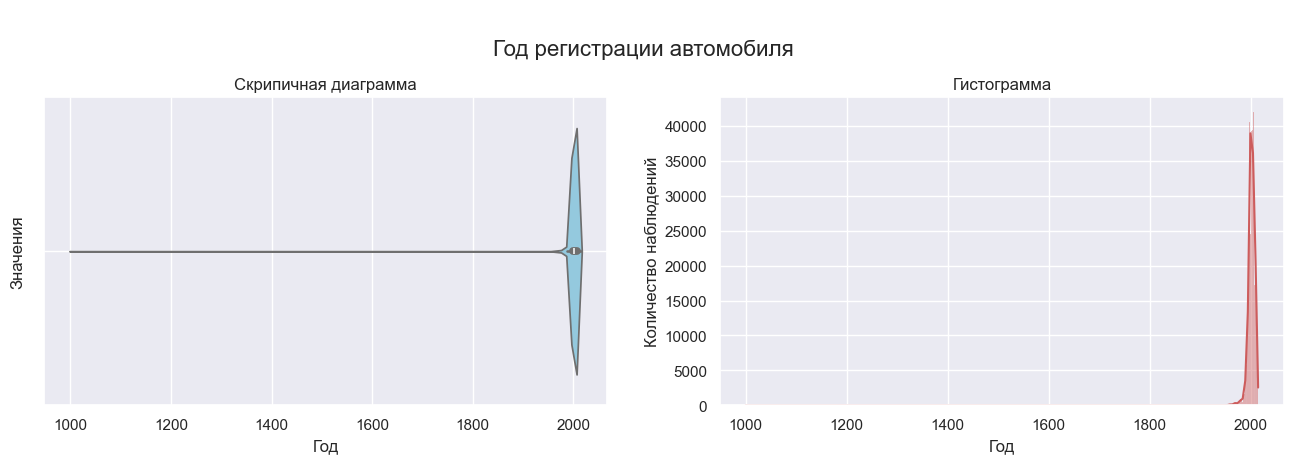

In [35]:
# рассмотрим распределение признака на графиках

hist_violin(autos, 'registration_year', 574, 'Год регистрации автомобиля', 'Год')

Видим по графикам, что выбросы сильно мешают оценить распределение. Попробуем дополнительно ограничить данные 1990-м годом по левой стороне

In [36]:
# сохраним получившийся срез данных

autos = autos.query('1990 <= registration_year')

In [37]:
# снова посмотрим на числовое описание столбца registration_year

describe(autos, 'registration_year', 'autos')

Числовое описание столбца registration_year таблицы autos:
 
count    320567.000000
mean       2002.768526
std           5.262677
min        1990.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: registration_year, dtype: float64


В таблице осталось 320567 наблюдений. Это значит, что мы избавились от почти 3% данных — потеря некритична, а данные о ценах на автомобили до 1990 года едва ли были бы нам полезны.

Так, минимальным в столбце является 1990-й год, а максимальным — 2015-й. Медиана делит данные таким образом, что в левой половине содержатся данные за 13 лет до 2003 года, а по правой стороне — за 12 лет после 2003 года. Можно сказать, что данные равномерно распределены по годам. Теперь взглянем, как имеющиеся наблюдения распределены в этих данных

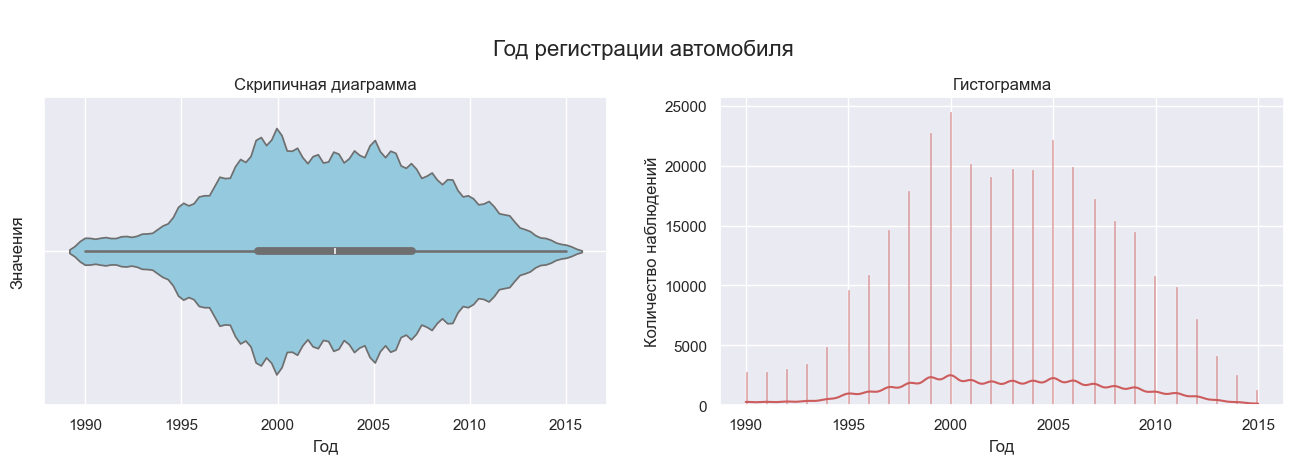

In [38]:
# рассмотрим распределение признака на графиках

hist_violin(autos, 'registration_year', 256, 'Год регистрации автомобиля', 'Год')

Видим плавный рост количества продаваемых автомобилей с 1990 по 2000 года, затем график стремится вниз, произведя небольшой скачок в 2005 году, и продолжает падать, пока не касается отметки 2015 года

## `price` — целевой признак

In [39]:
# посмотрим на числовое описание столбца price

describe(autos, 'price', 'autos')

Числовое описание столбца price таблицы autos:
 
count    320567.000000
mean       4532.545125
std        4554.699586
min           0.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


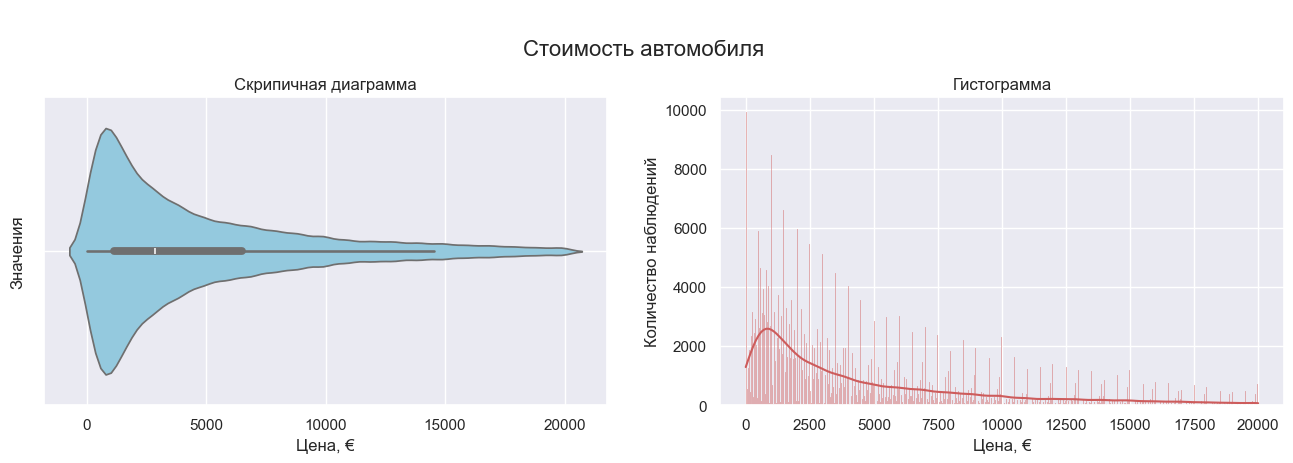

In [40]:
# рассмотрим распределение признака на графиках

hist_violin(autos, 'price', 533, 'Стоимость автомобиля', 'Цена, €')

Примерно половина от всех автомобилей в данных имеет стоимость 2850 евро или меньше. Такое вполне возможно, если говорить о старых моделях, либо подержанных или совсем сломанных авто. Попробуем снова ограничить данные, взяв за минимум стоимость автомобиля в 500 евро. 

По правой стороне графика видно, что не так уж и много автомобилей имеют относительно высокую цену — лишь 25% автомобилей имели цену выше 6500 евро, но эти автомобили не стоит считать выбросами. Возможно, эти высокие цены имеют отношение к последнему пику на предыдущем графике с годом регистрации, да и самая высокая стоимость, равная 20000 евро, является вполне реалистичной для автомобиля

In [41]:
# сохраним получившийся срез данных

autos = autos.query('500 <= price')

In [42]:
# снова посмотрим на числовое описание столбца price

describe(autos, 'price', 'autos')

Числовое описание столбца price таблицы autos:
 
count    290111.000000
mean       4987.719531
std        4554.062323
min         500.000000
25%        1500.000000
50%        3300.000000
75%        7000.000000
max       20000.000000
Name: price, dtype: float64


В среднем, стоимость автомобиля равна 4987 евро, по медиане — 3300 евро.

Удалено 30456 наблюдений, что равно 9% от оставшихся после предыдущего среза данных

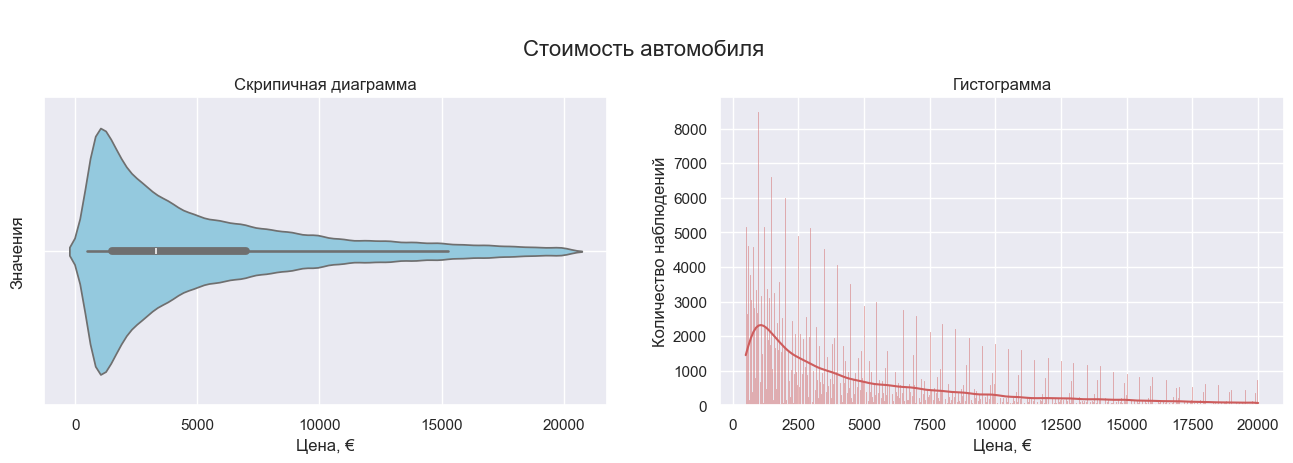

In [43]:
# снова рассмотрим распределение признака на графиках

hist_violin(autos, 'price', 538, 'Стоимость автомобиля', 'Цена, €')

## `vehicle_type` — тип автомобильного кузова

In [44]:
# посмотрим на числовое распределение данных в столбце vehicle_type

value_counts(autos, 'vehicle_type', 'autos')

Распределение данных в столбце vehicle_type таблицы autos:
 
vehicle_type
sedan          82346
small          67421
wagon          60346
bus            27350
convertible    18561
coupe          13543
suv            11289
unknown         6773
other           2482
Name: count, dtype: int64


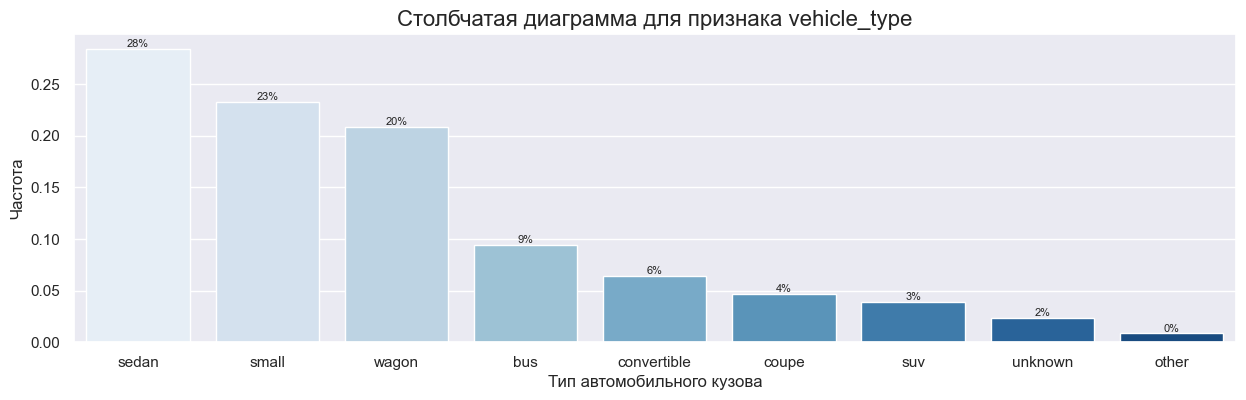

In [45]:
# рассмотрим распределение признака на графике

barplot(autos, 'vehicle_type', 'Тип автомобильного кузова', 'Столбчатая диаграмма для признака vehicle_type')

Самыми крупными являются такие категории автомобильного кузова, как *sedan*, *small* и *wagon*, имеющие 82346, 67421 и 60346 наблюдений соответственно. На последнем месте находится категория *other*, в ней находятся данные о 2482 автомобилях

## `gearbox` — тип коробки передач

In [46]:
# посмотрим на числовое распределение данных в столбце gearbox

value_counts(autos, 'gearbox', 'autos')

Распределение данных в столбце gearbox таблицы autos:
 
gearbox
manual     221033
auto        58985
unknown     10093
Name: count, dtype: int64


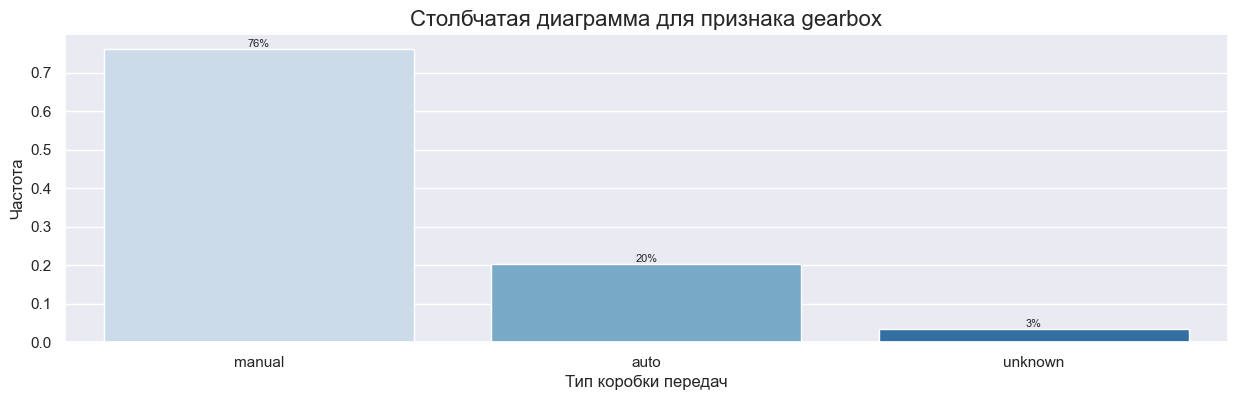

In [47]:
# рассмотрим распределение признака на графике

barplot(autos, 'gearbox', 'Тип коробки передач', 'Столбчатая диаграмма для признака gearbox')

76% автомобилей имели механическую коробку передач, 20% — автоматическую, об остальных транспортных средствах данные зафиксированы не были

## `power` — мощность

In [48]:
# посмотрим на числовое описание столбца power

describe(autos, 'power', 'autos')

Числовое описание столбца power таблицы autos:
 
count    290111.000000
mean        117.413931
std         180.333303
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64


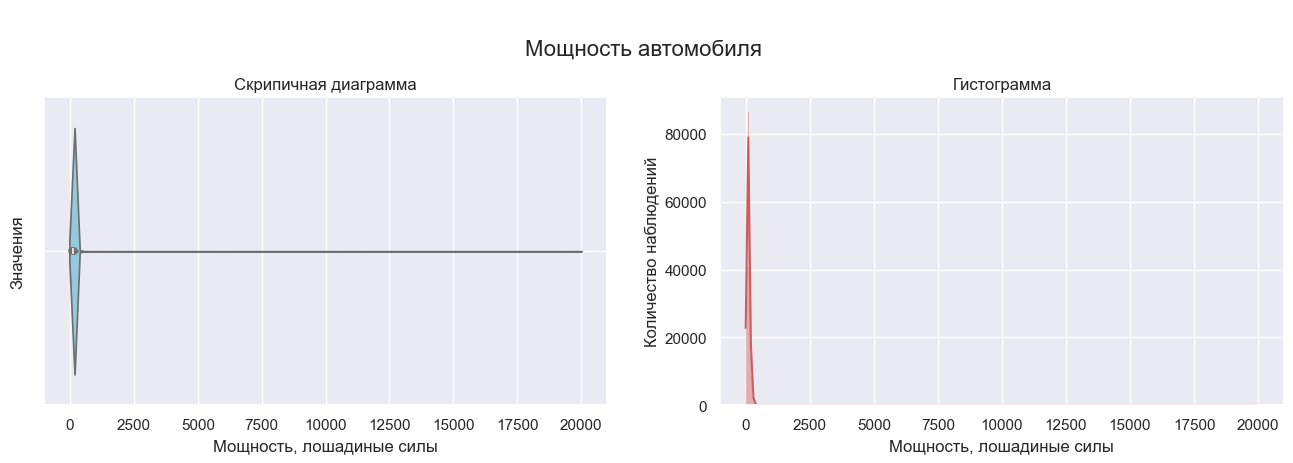

In [49]:
# рассмотрим распределение признака на графиках

hist_violin(autos, 'power', 538, 'Мощность автомобиля', 'Мощность, лошадиные силы')

Количество лошадиных сил в легковом автомобиле начинается от 90, хотя старые автомобили могут иметь и примерно 50 лошадиных сил. Вполне реалистичен тот факт, что такие старые автомобили могут быть выставлены на продажу, поэтому исключать их из данных не стоит. Ограничим левую сторону в 40 лошадиных сил.

Видим, что максимальная мощность в имеющихся данных достигает 20000 лошадиных сил, но это явный выброс. Существуют гоночные автомобили и различные грузовики-рекордсмены, чья мощность может достигать 2-4 тысяч лошадиных сил, но если мы взглянем на числовое описание столбца, то можем увидеть, что это не наш вариант. 75% данных ограничиваются всего 150 лошадиными силами, поэтому и мы ограничим данные по правой стороне отметкой в 1000 лошадиных сил, чтобы сохранить данные об автомобилях другого сегмента

In [50]:
# сохраним получившийся срез данных

autos = autos.query('40 <= power <= 1000')

In [51]:
# снова посмотрим на числовое описание столбца power

describe(autos, 'power', 'autos')

Числовое описание столбца power таблицы autos:
 
count    267374.000000
mean        123.989348
std          54.292768
min          40.000000
25%          84.000000
50%         116.000000
75%         150.000000
max        1000.000000
Name: power, dtype: float64


Удалено ещё почти 8% данных или 22737 строк.

Теперь средняя мощность равна ~124, по медиане — 116, а левая и правая границы соответствуют нашим условиям среза

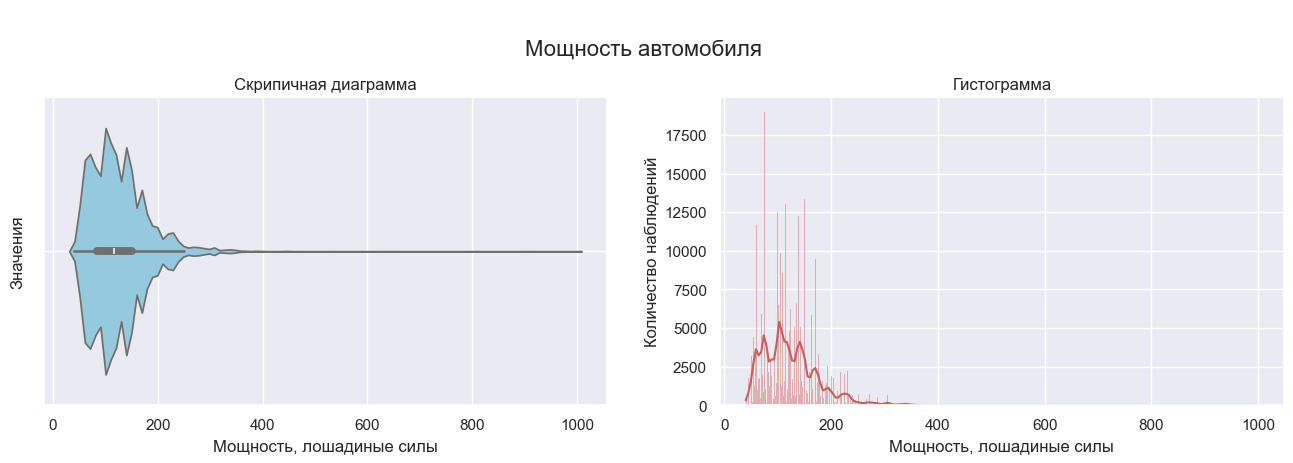

In [52]:
# снова рассмотрим распределение признака на графиках

hist_violin(autos, 'power', 517, 'Мощность автомобиля', 'Мощность, лошадиные силы')

Несмотря на то, что мы видим небольшое количество автомобилей, имеющих больше 400 лошадиных сил, эти наблюдения из данных исключать не стоит, так как модель не будет иметь примеров очень мощных или гоночных автомобилей и будет предсказывать цену для них на основе автомобилей совершенного другого сегмента

## `kilometer` — пробег

In [53]:
# посмотрим на числовое описание столбца kilometer

describe(autos, 'kilometer', 'autos')

Числовое описание столбца kilometer таблицы autos:
 
count    267374.000000
mean     128048.594852
std       36501.731179
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


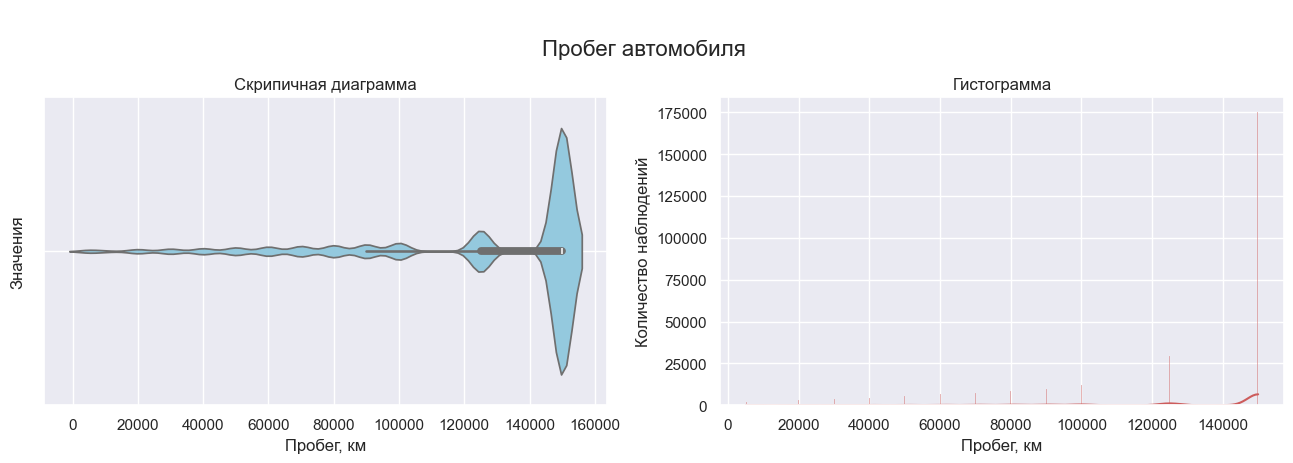

In [54]:
# рассмотрим распределение признака на графиках

hist_violin(autos, 'kilometer', 517, 'Пробег автомобиля', 'Пробег, км')

Минимальный пробег авто здесь равен 5000 километрам, максимальный — 150000. В среднем, пробег составил 128048 километров. 

На графиках видим пики через каждые 20 тысяч километров, что говорит о некой стандартизации этого параметра. Указывается не точное количество километров, а близкое к целому примерное значение. Примерно 75% данных составляют авто с пробегом выше 125000 километров, а 50% данных составляют автомобили с пробегом, равным 150000 километров. И минимальные, и максимальные значения являются вполне реалистичными, за выбросы их принимать нельзя. Можно лишь отметить, что большую часть автомобилей составляют подержанные, бывшие в долгом употреблении или очень старые авто

## `fuel_type` — тип топлива

In [55]:
# посмотрим на числовое распределение данных в столбце fuel_type

value_counts(autos, 'fuel_type', 'autos')

Распределение данных в столбце fuel_type таблицы autos:
 
fuel_type
petrol      166381
gasoline     85543
unknown      10242
lpg           4474
cng            460
hybrid         196
other           46
electric        32
Name: count, dtype: int64


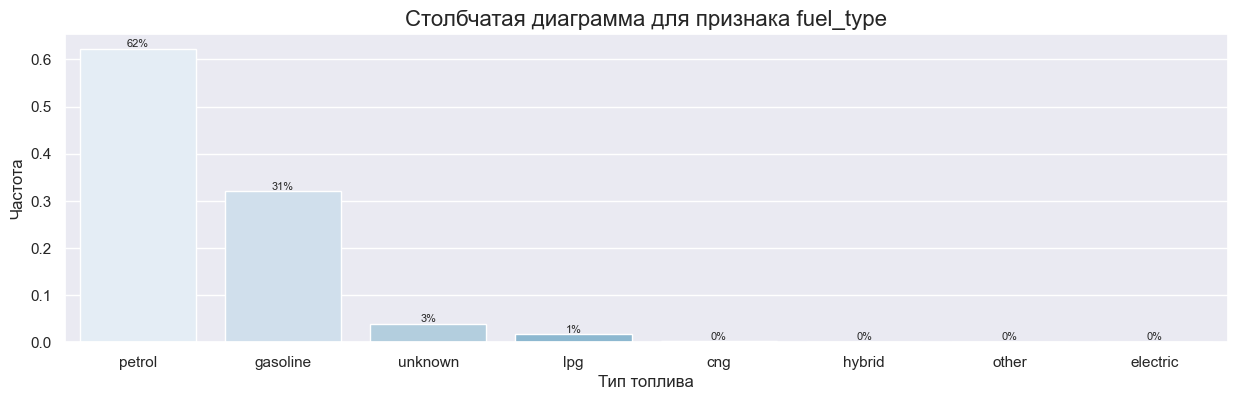

In [56]:
# рассмотрим распределение признака на графике

barplot(autos, 'fuel_type', 'Тип топлива', 'Столбчатая диаграмма для признака fuel_type')

Есть предположение, что *petrol* и *gasoline* — это один и тот же тип топлива, но обозначенный разными словами в завиисимости от страны. Так, машины на бензине составляют 94% от общего количества данных, машины на природном газе — 1.8%, остальной процент занимают оставшиеся четыре категории — гибридное топливо, электричество, другое и неизвестные значения

## `brand` — марка автомобиля

In [57]:
# посмотрим на числовое распределение данных в столбце brand

value_counts(autos, 'brand', 'autos')

Распределение данных в столбце brand таблицы autos:
 
brand
volkswagen        57242
bmw               30670
opel              27936
mercedes_benz     25443
audi              24266
ford              17714
renault           12036
peugeot            8657
fiat               6413
seat               5315
skoda              4789
smart              4370
mazda              4297
toyota             3874
citroen            3827
nissan             3627
hyundai            2985
mini               2906
volvo              2558
mitsubishi         2163
honda              2158
kia                1995
alfa_romeo         1749
suzuki             1743
chevrolet          1292
chrysler           1075
sonstige_autos     1068
dacia               787
subaru              564
jeep                531
daihatsu            501
porsche             495
land_rover          429
saab                428
jaguar              405
daewoo              328
lancia              304
rover               293
lada                132
trab

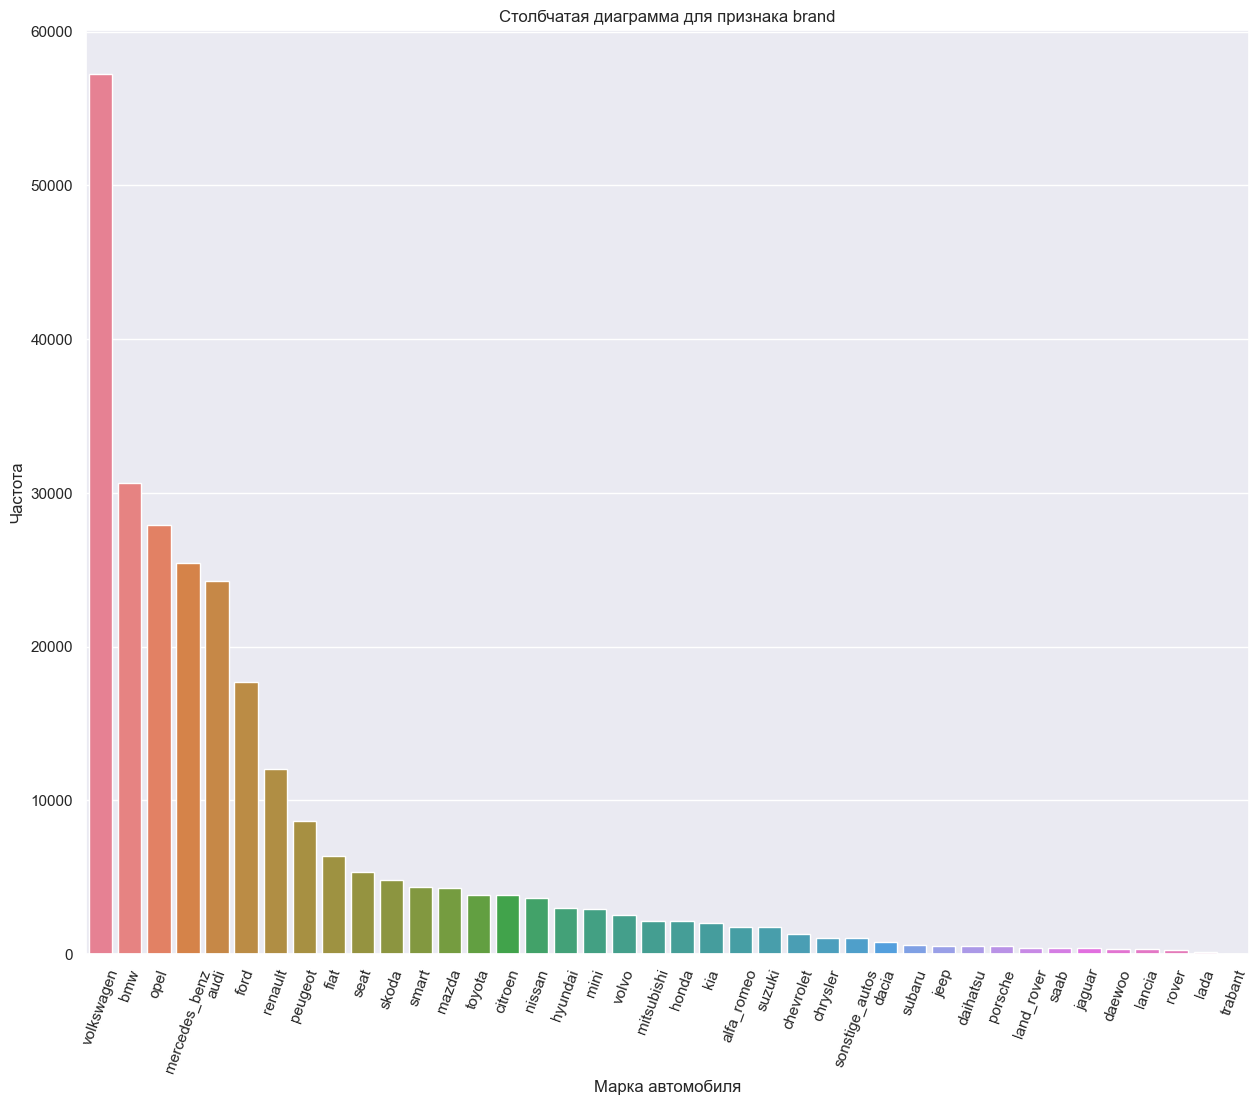

In [58]:
# рассмотрим распределение признака на графике

plt.figure(figsize=(15, 12))
data_new = autos['brand'].value_counts()
data_new_1 = data_new.reset_index()
data_new_1.columns = ['brand', 'count']
sns.barplot(x='brand', y='count', data=data_new_1, hue='brand', legend=False)

plt.title('Столбчатая диаграмма для признака brand')
plt.xlabel('Марка автомобиля')
plt.ylabel('Частота')

plt.xticks(rotation=70)

plt.show()

Самой распространённой маркой автомобиля является Volkswagen, она составляет 21% от этого количества данных. Второе, третье, четвёртое и пятое места делят между собой BMW, Opel, Mercedez-Benz и Audi соответственно, имея практически одинаковое количество автомобилей. Меньше всего в данных автомобилей марки Trabant

## `repaired` — была ли машина в ремонте

In [59]:
# посмотрим на числовое распределение данных в столбце repaired

value_counts(autos, 'repaired', 'autos')

Распределение данных в столбце repaired таблицы autos:
 
repaired
no         212071
unknown     33332
yes         21971
Name: count, dtype: int64


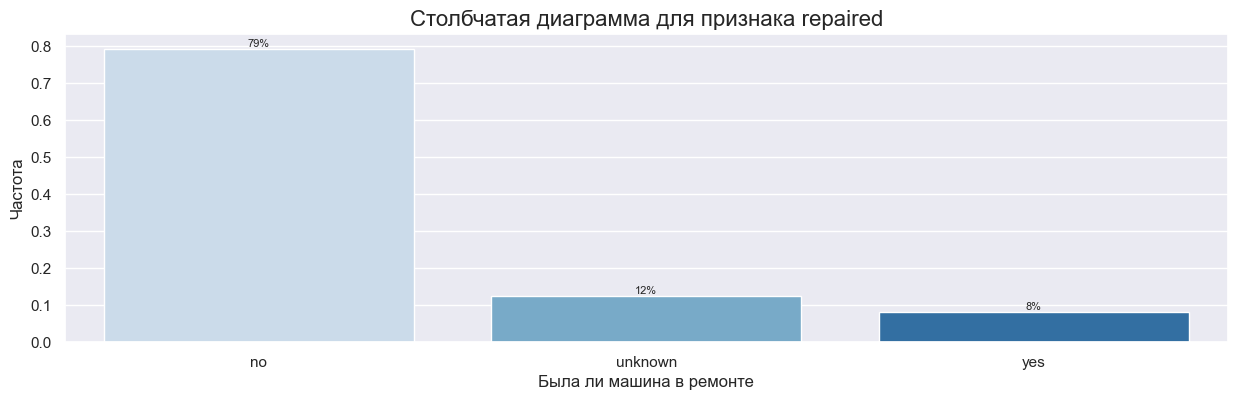

In [60]:
# рассмотрим распределение признака на графике

barplot(autos, 'repaired', 'Была ли машина в ремонте', 'Столбчатая диаграмма для признака repaired')

Лишь о 8% автомобилей указано, что они были в ремонте

---

Исследовательский анализ окончен, можно вернуться к дубликатам и оценить, насколько уменьшилось их количество после среза данных

In [61]:
# посчитаем строки-дубликаты

preprocess(autos, 'autos')

В таблице autos не найдено ни одного пропуска!
Дубликатов найдено в таблице autos: 37001


Количество дубликатов уменьшилось, но нам по-прежнему необходимо их удалить, чтобы продолжить подготовку к обучению модели

In [62]:
# удалим строки-дубликаты

autos = autos.drop_duplicates()

In [63]:
# выведем на экран общую информацию о таблице и проверим результат

get_info(autos)

Пять случайных строк таблицы:


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
21515,4490,wagon,2003,auto,197,e_klasse,150000,gasoline,mercedes_benz,no
220169,2750,small,2003,manual,75,2_reihe,125000,petrol,peugeot,no
179048,4300,small,2007,manual,60,corsa,90000,petrol,opel,no
223042,1500,bus,1996,manual,175,sharan,150000,lpg,volkswagen,unknown
250276,10800,wagon,2005,manual,224,a6,150000,gasoline,audi,no


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 230373 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              230373 non-null  int64 
 1   vehicle_type       230373 non-null  object
 2   registration_year  230373 non-null  int64 
 3   gearbox            230373 non-null  object
 4   power              230373 non-null  int64 
 5   model              230373 non-null  object
 6   kilometer          230373 non-null  int64 
 7   fuel_type          230373 non-null  object
 8   brand              230373 non-null  object
 9   repaired           230373 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.3+ MB
None


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Исследовательский анализ данных завершён. Устранены аномалии, выбросы, а также лишние неинформативные признаки и строки-дубликаты, появившиеся вследствие удаления этих признаков. Подробно изучены распределения данных в каждом столбце
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Корреляционный анализ данных
</div>

---

In [64]:
def phik(data, interval_cols):
                            
    """
    Функция phik выводит на экран матрицу корреляции phik

    Аргументы:
    data (DataFrame) : датафрейм
    interval_cols (list) : список названий столбцов, содержащих непрерывные количественные признаки
    
    """

    phik_matrix = data.phik_matrix(interval_cols=interval_cols)
    cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

    plt.figure(figsize=(10, 9))
    sns.heatmap(phik_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5)
    plt.xticks(rotation=60)
    plt.title(r'Матрица корреляции $\phi_K$')

    plt.show()

---

Оценим корреляцию между признаками. Так как в данных содержатся как категориальные, так и непрерывные признаки, используем метод **Phik**. Перед построением матрицы корреляции не требуется проводить статистический тест для определения нормальности распределений, поскольку Phik не предполагает нормальность данных

In [65]:
# создадим список с наименованиями непрерывных признаков

interval_cols = ['power', 'price']

Матрица корреляции для таблицы autos:
 


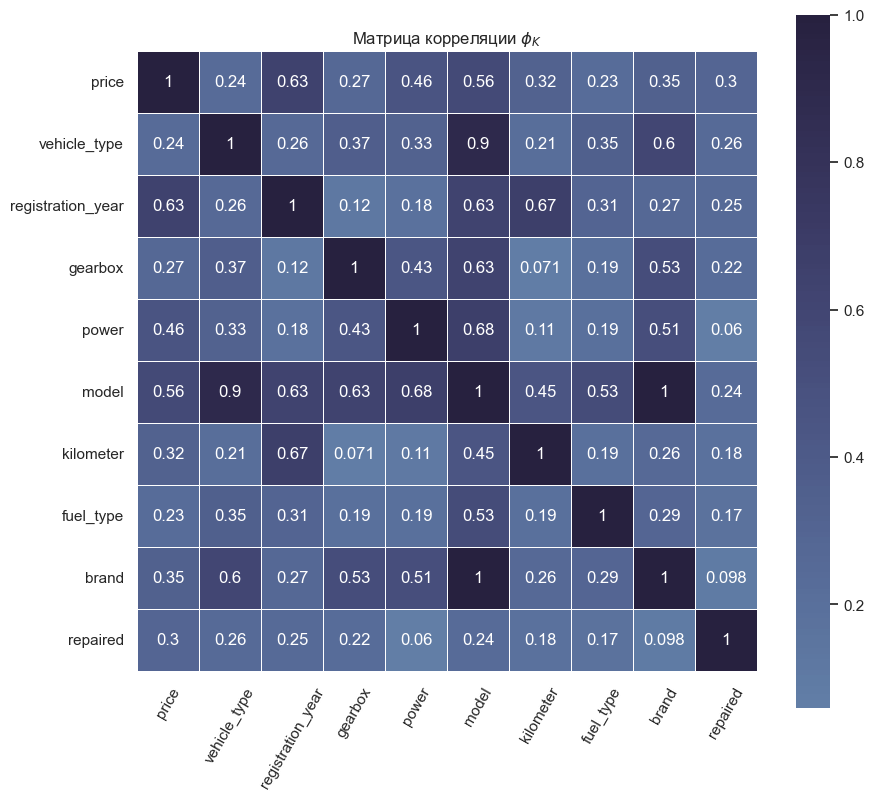

In [66]:
# выведем на экран матрицу корреляции

print('Матрица корреляции для таблицы autos:')
print(' ')
phik(autos, interval_cols)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Целевой признак практически одинаково коррелирует со всеми имеющимися признаками, но с признаками `registration_year`, `power` и `model` эта взаимосвязь заметно выше и составляет 0.63, 0.46 и 0.56 соответственно. Это значит, что цена автомобиля ощутимо зависит от года его регистрации, от его модели и мощности.

Обнаружена мультиколлинеарность у признаков `vehicle_type` и `model`, а также у `brand` и `model`. О мультиколлинеарности, как правило, говорят при значении коэффициента от 0.9 и выше по модулю, в нашем случае коэффициент корреляции `model` от признаков `vehicle_type` и `brand` составил 0.9 и 1 соответственно. Значит, тип автомобильного кузова и марка автомобиля сильно зависят от его модели. В этом случае мультиколлинеарность нам не страшна, ведь мы не собираемся использовать линейные модели.

Взаимосвязь года регистрации авто и его модели равна 0.63, взаимосвязь с пробегом — 0.67. Тип коробки передач также умеренно зависит от мощности, модели и марки авто. Ожидаемо, мощность автомобиля коррелирует с типом его коробки передач, а также с маркой транспортного средства. Тип топлива также коррелирует с мооделью авто.

Примечательно, что признак `model` значительно коррелирует практически с каждым другим признаком. А вот `repaired`, напротив, не влияет ни на один признак, кроме целевого — то есть, цены автомобиля

    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Подготовка данных к обучению
</div>

---

In [67]:
def split(data, target):
                                        
    """
    Функция split делит данные на тренировочную и тестовую выборки
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : целевой признак
    
    """
    X = data.drop(columns=target, axis=1)
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    return X_train, X_test, y_train, y_test

In [68]:
def train_test_size(X_train, X_test, y_train, y_test):
                                    
    """
    Функция train_test_size выводит на экран размерность разделённых на выборки данных
    
    Аргументы:
    X_train (DataFrame) : входные признаки тренировочной выборки
    X_test (DataFrame) : входные признаки тестовой выборки
    y_train (Series) : целевой признак тренировочной выборки
    y_test (Series) : целевой признак тестовой выборки
    
    """

    print('Тренировочная выборка')
    print(f'Размерность матрицы со входными признаками: {X_train.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_train.shape}')
    print(' ')
    print('Тестовая выборка')
    print(f'Размерность матрицы со входными признаками: {X_test.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_test.shape}')

---

In [69]:
# выделим количественные признаки для их последующего кодирования

num_cols = ['power']

Признаки `kilometer` и `registration_year` имеют распределение категориальных признаков, так как задано небольшое количество уникальных значений — с ними тоже стоит работать как с категориями

In [70]:
# переменную с категориальными признаками превратим в список

cat_cols = cat_cols.to_list()

In [71]:
# добавим в список ещё два признака

cat_cols.append('kilometer')
cat_cols.append('registration_year')

In [72]:
# проверим результат

print(f'Итоговый список категориальных признаков: {cat_cols}')

Итоговый список категориальных признаков: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'kilometer', 'registration_year']


---

In [73]:
# разделим данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = split(autos, TARGET)

In [74]:
# изменим тип данных object на category 

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

In [75]:
# проверим размерность получившихся выборок

train_test_size(X_train, X_test, y_train, y_test)

Тренировочная выборка
Размерность матрицы со входными признаками: (172779, 9)
Размерность матрицы с целевым признаком: (172779,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (57594, 9)
Размерность матрицы с целевым признаком: (57594,)


In [76]:
# проверим типы данных в выборках

print('Тренировочная выборка:')
display(X_train.dtypes)
print(' ')
print('Тестовая выборка:')
display(X_test.dtypes)

Тренировочная выборка:


vehicle_type         category
registration_year    category
gearbox              category
power                   int64
model                category
kilometer            category
fuel_type            category
brand                category
repaired             category
dtype: object

 
Тестовая выборка:


vehicle_type         category
registration_year    category
gearbox              category
power                   int64
model                category
kilometer            category
fuel_type            category
brand                category
repaired             category
dtype: object

---

In [77]:
# StandardScaler

num_pipe = Pipeline(
    steps=[
        (
            'scaler', 
            StandardScaler()
        )
    ]
)

# OrdinalEncoder

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        )
    ]
)

# ColumnTransformer

data_preprocessor = ColumnTransformer(
    transformers=[
        (
            'ord',
            ord_pipe, cat_cols
        ),
        (
            'num',
            num_pipe, num_cols
        ),
    ],
    remainder='passthrough'
)

Этот пайплайн закодирует категориальные данные с помощью `OrdinalEncoder`, количественные — масштабирует с помощью `StandardScaler`; если в данных во время или вследствие кодирования категориальных признаков возникнут пропуски, они заполнятся самым часто встречающимся значением с помощью `SimpleImputer`. Третья труба `data_preprocessor` применит `OrdinalEncoder` и `StandardScaler` к данным. Итоговых пайплайнов для подготовки данных будет три — по одному на каждую из моделей

In [78]:
def pipeline(pipe_final, param_grid, X_train, y_train):
    
    """
    Функция pipeline выполняет подбор гиперпараметров с помощью RandomizedSearch,
    повторно обучает модель с лучшими параметрами на тренировочных данных,
    делает предсказания на тестовых данных с помощью этой лучшей модели и замеряет время, затраченное на каждое из этих действий
    
    Аргументы:
    pipe_final : пайплайн
    param_grid (dict) : cловарь с гиперпараметрами
    X_train (numpy.array) : входные признаки тренировочной выборки
    y_train (numpy.array) : целевой признак тренировочной выборки
    
    Возвращает:
    rs_time : время, затраченное на поиск лучших параметров
    best_model : модель
    best_params : лучшие параметры модели
    rmse: метрика RMSE, посчитанная на тренировочной выборке
    train_time : время, затраченное на обучение модели
    prediction_time : время, затраченное на предсказания модели
    
    """
    
    start_rs_time = time()
    rs = RandomizedSearchCV(pipe_final, param_grid, n_jobs=-1, cv=5,scoring='neg_mean_squared_error', random_state=RANDOM_STATE)
    rs.fit(X_train, y_train)
    end_rs_time = time()
    rs_time = end_rs_time - start_rs_time
    
    best_params = rs.best_params_
    best_model = rs.best_estimator_
    rmse = np.sqrt(abs(rs.best_score_))

    start_train_time = time()
    best_model.fit(X_train, y_train)
    end_train_time = time()
    train_time = end_train_time - start_train_time
    
    start_prediction_time = time()
    predictions = best_model.predict(X_train)
    end_prediction_time = time()
    prediction_time = end_prediction_time - start_prediction_time

    return rs_time, best_model, best_params, rmse, train_time, prediction_time

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Выборки были сформированы корректно. Можно приступать к обучению моделей

</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей
</div>

---

Помня об условии задачи, а также о мультиколлинеарности в данных и большом количестве категориальных признаков, помимо `LightGBM` выберем такие модели, как `DecisionTreeRegressor` и `CatBoost`

## `DecisionTreeRegressor`

In [79]:
# итоговый пайплайн для модели DecisionTreeRegressor

pipe_final_1 = Pipeline(
    [
        (
            'preprocessor',
            data_preprocessor
        ),
        (
            'decision_tree_regressor',
            DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

In [80]:
# создадим словарь с гиперпараметрами

param_grid_1 = {
        'decision_tree_regressor__max_depth': range(1, 20),
        'decision_tree_regressor__max_features': range(2,50),
        'decision_tree_regressor__min_samples_leaf': range(1,5),
        'decision_tree_regressor__min_samples_split': range(3, 20)
}

In [81]:
# применим функцию pipeline

rs_time_1, model_1, best_params_1, rmse_1, train_time_1, prediction_time_1 = pipeline(pipe_final_1, param_grid_1, X_train, y_train)

## `LightGBM`

In [82]:
# итоговый пайплайн для модели LightGBM

pipe_final_2 = Pipeline(
    [
        (
            'preprocessor',
            data_preprocessor
        ),
        (
            'lgbm',
            LGBMRegressor()
        )
    ]
)

In [83]:
# создадим словарь с гиперпараметрами

param_grid_2 = {'lgbm__max_depth': range(1, 15)}

In [84]:
# применим функцию pipeline

rs_time_2, model_2, best_params_2, rmse_2, train_time_2, prediction_time_2 = pipeline(pipe_final_2, param_grid_2, X_train, y_train)

D:\programs\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\programs\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 172779, number of used features: 9
[LightGBM] [Info] Start training from score 5282.971316
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

## `CatBoost`

In [85]:
# итоговый пайплайн для модели CatBoost

pipe_final_3 = Pipeline(
    [
        (
            'preprocessor',
            data_preprocessor
        ),
        (
            'catboost',
            CatBoostRegressor(loss_function='RMSE', verbose=25)
        )
    ]
)

In [86]:
# создадим словарь с гиперпараметрами

param_grid_3 = {'catboost__iterations': range(50, 150)}

In [87]:
# применим функцию pipeline

rs_time_3, model_3, best_params_3, rmse_3, train_time_3, prediction_time_3 = pipeline(pipe_final_3, param_grid_3, X_train, y_train)

Learning rate set to 0.485364
0:	learn: 3253.4727452	total: 152ms	remaining: 19.6s
25:	learn: 1690.8457265	total: 338ms	remaining: 1.35s
50:	learn: 1605.6205201	total: 526ms	remaining: 814ms
75:	learn: 1560.7947389	total: 717ms	remaining: 509ms
100:	learn: 1531.1353303	total: 921ms	remaining: 265ms
125:	learn: 1508.9679234	total: 1.13s	remaining: 35.8ms
129:	learn: 1505.5090987	total: 1.16s	remaining: 0us
Learning rate set to 0.485364
0:	learn: 3253.4727452	total: 8.33ms	remaining: 1.07s
25:	learn: 1690.8457265	total: 189ms	remaining: 757ms
50:	learn: 1605.6205201	total: 378ms	remaining: 586ms
75:	learn: 1560.7947389	total: 574ms	remaining: 408ms
100:	learn: 1531.1353303	total: 776ms	remaining: 223ms
125:	learn: 1508.9679234	total: 987ms	remaining: 31.3ms
129:	learn: 1505.5090987	total: 1.02s	remaining: 0us


---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Выбор лучшей модели
</div>

---

In [88]:
# объединим результаты в датафрейм

models_results_list = {
    'model': ['decision_tree_regressor', 'lgbm', 'catboost'],
    'train_time': [train_time_1, train_time_2, train_time_3],
    'prediction_time': [prediction_time_1, prediction_time_2, prediction_time_3],
    'rmse_train': [rmse_1, rmse_2, rmse_3]
}

models = pd.DataFrame(models_results_list)

In [89]:
# оценим результат

models

,model,train_time,prediction_time,rmse_train
0,decision_tree_regressor,0.655956,0.216197,1752.263269
1,lgbm,0.826212,0.381639,1602.953071
2,catboost,1.687566,0.513372,1561.317470


`DecisionTreeRegressor` показала на тренировочной выборке результат RMSE, равный 1752, `LightGBM` — 1603, а `CatBoost` — 1561. Каждая из трёх моделей соответствует основному требованию к целевой метрике, но лучшей из моделей является `CatBoostRegressor`. Заказчику также важно время обучения модели, а самой быстрой по этому критерию является `LightGBM`, время обучения которой равно 0.85. Две другие модели обучаются чуть медленнее, но остаются на одном друг с другом уровне. 

Так как заказчику важны и RMSE, и время обучения и предсказания модели в совокупности, то для использования можно посоветовать именно `LightGBM`, как занимающую первое место по скорости обучения и второе место — по скорости предсказания, но при этом более чем удовлетворяющую критерий RMSE

In [90]:
# выведем на экран лучшие параметры модели

display('Лучшие параметры для модели LightGBM:', best_params_2)

'Лучшие параметры для модели LightGBM:'

{'lgbm__max_depth': 13}

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Тестирование лучшей модели
</div>

---

In [91]:
# выполним предсказания модели на тестовой выборке

predictions_2 = model_2.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [92]:
# посчитаем RMSE на тестовой выборке

rmse_test_2 = mean_squared_error(y_test, predictions_2, squared=False)

In [93]:
# сформируем таблицу и визуализируем в ней результат

result = {
    'model': ['lgbm'],
    'train_time': [train_time_2],
    'prediction_time': [prediction_time_2],
    'rmse_train': [rmse_2],
    'rmse_test': [rmse_test_2]
}

model = pd.DataFrame(result)

In [94]:
# оценим получившуюся таблицу

model.set_index('model')

,train_time,prediction_time,rmse_train,rmse_test
model,,,,
lgbm,0.826212,0.381639,1602.953071,1586.651598


`LightGBM` показала результат RMSE в 1586 на тестовой выборке. Хороший результат!

---

Инициализируем и обучим модель DummyRegressor, а затем сравним её метрику с метрикой нашей лучшей модели, чтобы оценить адекватность проделанной работы. DummyRegressor предсказывает средние значения, и если его метрики будут выше метрик нашей модели, это будет значить, что даже эта базовая модель работает лучше, а получившаяся модель `LightGBM` не принесёт пользы

In [95]:
def dummy_regressor_test(best_model_name):
    
    """
    Функция dummy_regressor_test инициализирует модель Dummy Regressor,
    обучает её на тренировочной выборке, выполняет предсказания на тестовой выборке,
    вычисляет метрику RMSE, а затем строит сравнительную таблицу для тестовых значений
    лучшей модели и модели Dummy Regressor 
    
    Аргументы:
    best_model_name (str) : название лучшей модели
    
    Возвращает:
    dummy_result (DataFrame) : таблица со сравнительным результатом
    
    """
    
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train, y_train)
    dummy_pred = dummy.predict(X_test)
    dummy_rmse = mean_squared_error(y_test, dummy_pred, squared=False)
    
    dummy_result = {
        'model': [best_model_name, 'dummy_regressor'],
        'RMSE': [rmse_test_2, dummy_rmse]
    }
    
    dummy_result = pd.DataFrame(dummy_result)
    
    return dummy_result

In [96]:
# применим функцию dummy_regressor_test

dummy_result = dummy_regressor_test('lgbm')

# оценим результат

dummy_result

,model,RMSE
0,lgbm,1586.651598
1,dummy_regressor,4642.107553


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

- `RMSE модели LightGBM`: 1586.651598
- `RMSE модели DummyRegressor`: 4642.107553

Очевидно, наша лучшая модель **не** является бесполезной. Чем метрика RMSE ниже, тем лучше — а на `DummyRegressor` она гораздо выше
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

В ходе предобработки были успешно обработаны пропуски и удалены дубликаты, названия столбцов были приведены к стандарту оформления данных. Необходимый срез актуальных данных был проведён во время исследовательского анализа, а также подробно изучены сами данные, основные тенденции в них и зависимости между признаками. 

Были обучены следующие модели: `DecisionTreeRegressor`, `LightGBM` и `CatBoost`. По итогам обучения лучшей оказалась модель `LightGBM` со следующими гиперпараметрами:

- `lgbm__max_depth`: 13

Лучшая модель имеет следующие значения RMSE:

- `RMSE на тренировочной выборке`: 1602.9530708972213
- `RMSE на тестовой выборке`: 1586.6515978729988

Лучшая модель также прошла проверку на адекватность, совершённую с помощью константной модели `DummyRegressor`:

- `RMSE для модели LightGBM`: 1586.651598
- `RMSE для модели DummyRegressor`: 4642.107553

Каждая из трёх обученных моделей отвечает основному требованию задачи — чтобы метрика RMSE была меньше 2500. Итоговый выбор модели основан на соблюдении баланса качества и скорости модели. Так, самой быстрой по скорости обучения является модель `LightGBM`, по качеству она занимает второе место среди двух других моделей. Самая маленькая скорость обучения получилась у `CatBoost`, посередине — `DecisionTreeRegressor`, однако качество `CatBoost` относительно двух других моделей является самым высоким и надёжным

---